# Train Stats

```
 ----------------------------------------------------------------------------------------
/                                                                                        \
| /$$$$$$$$                 /$$            /$$$$$$   /$$                 /$$             |
||__  $$__/                |__/           /$$__  $$ | $$                | $$             |
|   | $$  /$$$$$$  /$$$$$$  /$$ /$$$$$$$ | $$  \__//$$$$$$    /$$$$$$  /$$$$$$   /$$$$$$$|
|   | $$ /$$__  $$|____  $$| $$| $$__  $$|  $$$$$$|_  $$_/   |____  $$|_  $$_/  /$$_____/|
|   | $$| $$  \__/ /$$$$$$$| $$| $$  \ $$ \____  $$ | $$      /$$$$$$$  | $$   |  $$$$$$ |
|   | $$| $$      /$$__  $$| $$| $$  | $$ /$$  \ $$ | $$ /$$ /$$__  $$  | $$ /$$\____  $$|
|   | $$| $$     |  $$$$$$$| $$| $$  | $$|  $$$$$$/ |  $$$$/|  $$$$$$$  |  $$$$//$$$$$$$/|
|   |__/|__/      \_______/|__/|__/  |__/ \______/   \___/   \_______/   \___/ |_______/ |
|                                                                                        |
|                                                                                        |
|                                                                                        |
|                                      🚂 ¯\_(ツ)_/¯?                                     |
\                                                                                        /
 ----------------------------------------------------------------------------------------
    \     
     \     
      \      
           ___ ____
         ⎛   ⎛ ,----
          \  //==--'
     _//|,.·//==--'    ____________________________
    _OO≣=-  ︶ ᴹw ⎞_§ ______  ___\ ___\ ,\__ \/ __ \
   (∞)_, )  (     |  ______/__  \/ /__ / /_/ / /_/ /
     ¨--¨|| |- (  / ______\____/ \___/ \__^_/  .__/
         ««_/  «_/ jgs/bd808                /_/
```

In which I look at data from the past several hundred trains and pretend that I know how to do exploratory data analysis.

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine
    
engine = create_engine('sqlite:///data/train.db')
df = pd.read_sql('''
SELECT
    version,
    rollbacks,
    rollbacks_time,
    group2_delay_days,
    (group0_delay_days +
     group1_delay_days +
     group2_delay_days) as total_delay,
    total_time as train_total_time,
    (select count(*) from blocker b where b.train_id = t.id) as blockers,
    (select count(*) from blocker b where b.train_id = t.id and resolved = 1) as resolved_blockers,
    patches,
    (select max(time_in_review) from patch p where p.train_id = t.id) as max_time_in_review,
    (select max(comments) from patch where patch.train_id = t.id) as max_comments_per_patch,
    (select max(start_time - created) from patch p where p.train_id = t.id) as max_cycle_time
FROM train t
''', engine)

# Makes your data 538% better...I think
plt.style.use('fivethirtyeight')
df.head()

,version,rollbacks,rollbacks_time,group2_delay_days,total_delay,train_total_time,blockers,resolved_blockers,patches,max_time_in_review,max_comments_per_patch,max_cycle_time
0,1.37.0-wmf.1,0,0,0,0,178349,5,3,450,36809044,27,36952873
1,1.37.0-wmf.3,3,94493,0,1,219880,7,6,366,56122286,30,56562620
2,1.37.0-wmf.4,1,66812,1,3,263742,9,4,422,38820872,29,38982601
3,1.36.0-wmf.1,0,0,4,4,519622,1,1,566,47181045,31,47755190
4,1.36.0-wmf.2,4,389769,4,5,554704,7,1,273,110996452,33,111569626


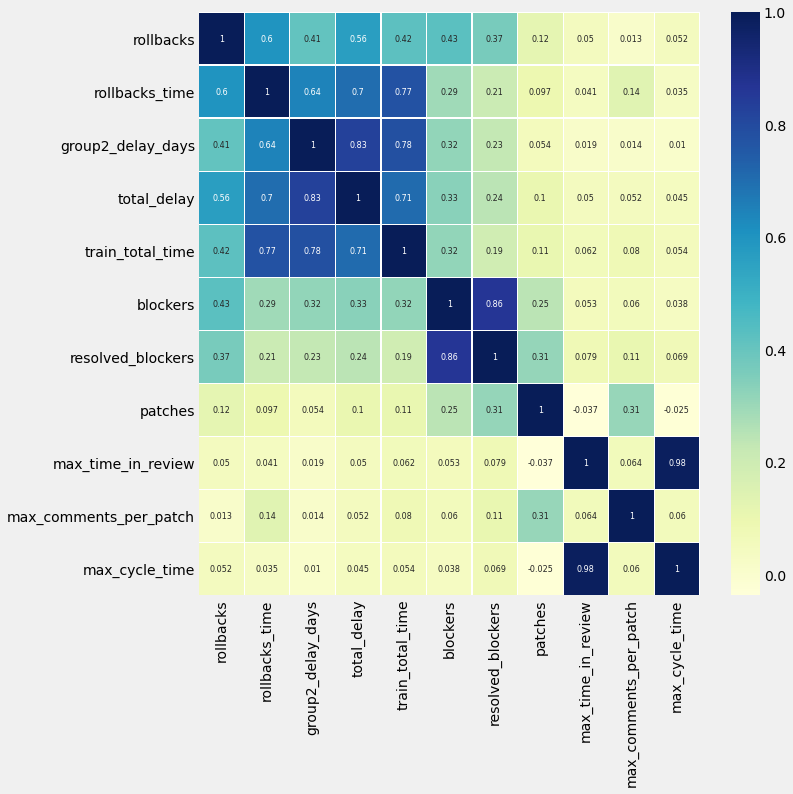

In [3]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu", linewidths=0.3, annot_kws={"size": 8}, ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

Text(0.5, 1.02, 'Blockers per Train')

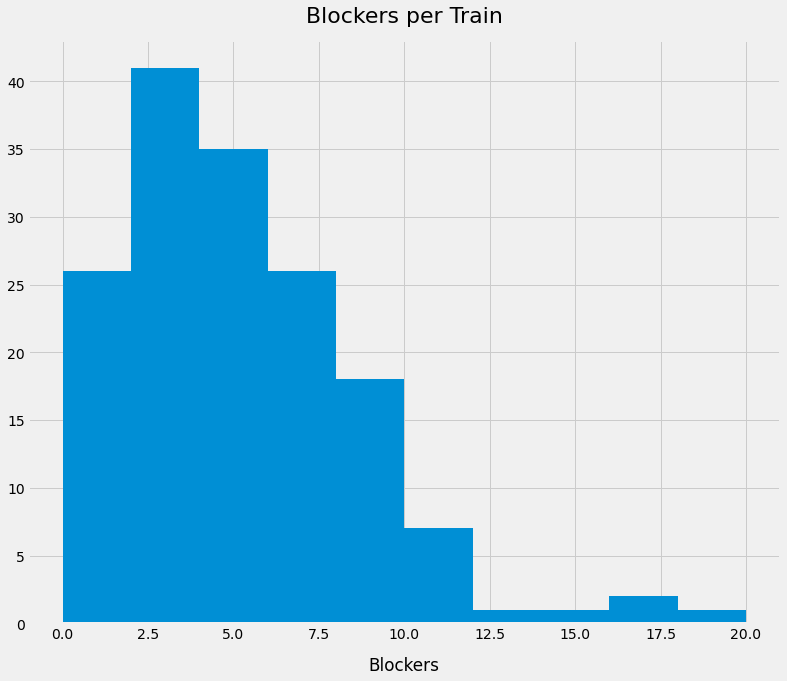

In [4]:
df.set_index('version')['blockers'].hist(figsize=(12, 10))
plt.xlabel("Blockers", labelpad=15)
plt.title("Blockers per Train", y=1.02, fontsize=22)

In [5]:
df[df['blockers'] > 10].sort_values(by='blockers', ascending=False)

,version,rollbacks,rollbacks_time,group2_delay_days,total_delay,train_total_time,blockers,resolved_blockers,patches,max_time_in_review,max_comments_per_patch,max_cycle_time
82,1.34.0-wmf.20,1,16897,5,5,600096,20,11,413,60583935,37,60715205
103,1.33.0-wmf.22,0,0,0,1,63844,17,11,391,107411197,45,107659715
77,1.34.0-wmf.14,2,412678,4,5,524983,16,7,646,73502579,34,73539481
136,1.31.0-wmf.20,2,134534,1,5,255075,14,12,822,66099647,75,67210868
124,1.32.0-wmf.22,0,0,0,0,173055,12,7,824,64869761,44,65392036
57,1.35.0-wmf.31,3,365118,4,15,516489,11,7,427,72215548,70,72206585
76,1.34.0-wmf.13,2,14912,0,1,183853,11,8,471,53208155,23,53820019


In [6]:
block_df = pd.read_sql('''
SELECT
    version,
    group_blocked
FROM train t
JOIN blocker b ON t.id = b.train_id
''', engine)
block_df.head()

,version,group_blocked
0,1.37.0-wmf.7,-1
1,1.37.0-wmf.7,-1
2,1.37.0-wmf.12,2
3,1.37.0-wmf.12,1
4,1.37.0-wmf.12,1


In [7]:
block_df.group_blocked.unique()

array([-1,  2,  1,  0])

In [8]:
group_name_map = {
    -1: "Earlier",
    0: "Group0",
    1: "Group1",
    2: "Group2",
}
block_df['blocker_added'] = block_df.group_blocked.map(group_name_map)
block_df.head()

,version,group_blocked,blocker_added
0,1.37.0-wmf.7,-1,Earlier
1,1.37.0-wmf.7,-1,Earlier
2,1.37.0-wmf.12,2,Group2
3,1.37.0-wmf.12,1,Group1
4,1.37.0-wmf.12,1,Group1


In [9]:
block_df.group_blocked.value_counts()

-1    244
 1    235
 0    181
 2     93
Name: group_blocked, dtype: int64

In [10]:
block_df.version

0       1.37.0-wmf.7
1       1.37.0-wmf.7
2      1.37.0-wmf.12
3      1.37.0-wmf.12
4      1.37.0-wmf.12
           ...      
748    1.37.0-wmf.18
749    1.37.0-wmf.18
750    1.37.0-wmf.18
751    1.37.0-wmf.18
752    1.37.0-wmf.18
Name: version, Length: 753, dtype: object

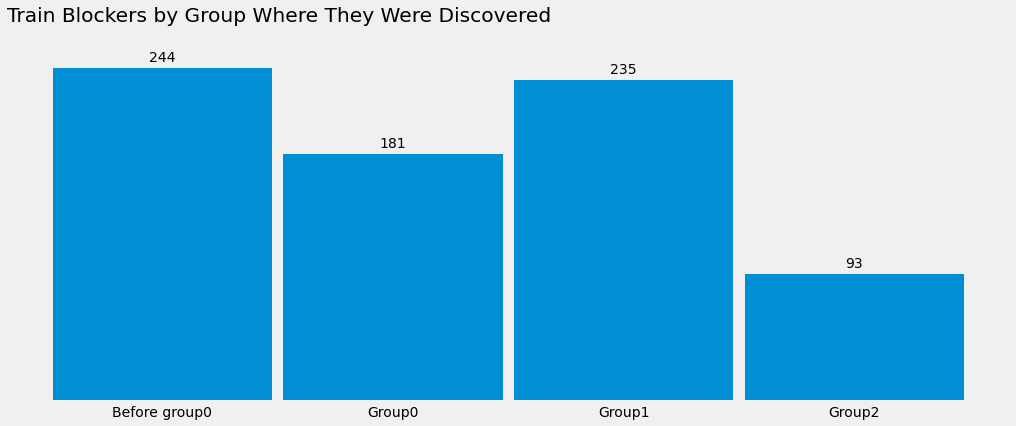

In [11]:
block_df.set_index('version')
block_df.sort_values('group_blocked', inplace=True)


fig = plt.figure(figsize=(16,6))
plt.grid(color='white', lw=0.5, axis='x')
n, bins, patches = plt.hist(block_df.blocker_added, bins=4, rwidth=0.95)

xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
xticks_labels = [ "{:.2f}\nto\n{:.2f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels=["Before group0", "Group0", "Group1", "Group2"])

# remove y ticks
plt.yticks([])

# plot values on top of bars
for idx, value in enumerate(n):
    if value > 0:
        plt.text(xticks[idx], value+5, int(value), ha='center')

plt.title('Train Blockers by Group Where They Were Discovered', loc='left', pad=30)
plt.show()


In [12]:
patches = pd.read_sql('''
SELECT
    link,
    version,
    submitted,
    insertions as ins,
    (deletions*-1) as del
FROM patch p JOIN train t ON t.id = p.train_id
''', engine)
patches.describe()

,submitted,ins,del
count,6.161400e+04,6.161400e+04,6.161400e+04
mean,1.568369e+09,4.153018e+02,-3.599921e+02
std,3.353360e+07,6.971539e+04,6.699696e+04
min,1.431572e+09,0.000000e+00,-1.661412e+07
25%,1.539219e+09,2.000000e+00,-1.700000e+01
50%,1.570374e+09,6.000000e+00,-4.000000e+00
75%,1.594246e+09,3.100000e+01,-1.000000e+00
max,1.628584e+09,1.728860e+07,0.000000e+00


In [13]:
patches['loc'] = patches['ins'] + patches['del']
patches.head()

,link,version,submitted,ins,del,loc
0,"https://gerrit.wikimedia.org/r/#/q/ccbfcf28,n,z",1.37.0-wmf.1,1618945759,5,-1,4
1,"https://gerrit.wikimedia.org/r/#/q/3302274f,n,z",1.37.0-wmf.1,1618878371,1156,-660,496
2,"https://gerrit.wikimedia.org/r/#/q/8b5471b5,n,z",1.37.0-wmf.1,1618343309,976,-3,973
3,"https://gerrit.wikimedia.org/r/#/q/a6abbb67,n,z",1.37.0-wmf.1,1618341075,8,-29,-21
4,"https://gerrit.wikimedia.org/r/#/q/af916aad,n,z",1.37.0-wmf.1,1618300868,7,-5,2


In [14]:
patches['submitted'] = pd.to_datetime(patches['submitted'], unit='s')
patches.set_index('submitted', inplace=True)

In [15]:
out = patches.groupby(pd.Grouper(freq='M')).apply(lambda x: x)
out = out[out['link'] != 'https://gerrit.wikimedia.org/r/#/q/9a08dbab,n,z'] # The one patch that inserts 17.2M lines of code
out['ok'] = out['loc'].cumsum()

## Cycle time/Lead time

**Cycle time** is the time from when a patch enters code review to the time that it's in production. **Lead time** is the time it takes from commit to production.

In [34]:
# GOAL
#         train     lead_time    cycle_time   Id
# 0    1.37.0-wmf.6    200   2000   u1234
# 1    1.37.0-wmf.6    123   2800   u1235

cycle = pd.read_sql('''
SELECT
    substr(version, 8) as version,
    datetime(start_time, 'unixepoch'),
    (start_time - created) as cycle_time,
    (start_time - submitted) as lead_time,
    datetime(created, 'unixepoch'),
    datetime(submitted, 'unixepoch'),
    link
FROM patch p JOIN train t ON t.id = p.train_id
WHERE (lead_time > 0 AND cycle_time > 0)
    AND (
        version = '1.37.0-wmf.14' OR
        version = '1.37.0-wmf.15' OR
        version = '1.37.0-wmf.16' OR
        version = '1.37.0-wmf.18'
    )
''', engine)
cycle.head()

,version,"datetime(start_time, 'unixepoch')",cycle_time,lead_time,"datetime(created, 'unixepoch')","datetime(submitted, 'unixepoch')",link
0,wmf.14,2021-07-13 22:15:46,50935,49822,2021-07-13 08:06:51,2021-07-13 08:25:24,https://gerrit.wikimedia.org/r/q/704204
1,wmf.14,2021-07-13 22:15:46,3619864,66729,2021-06-02 00:44:42,2021-07-13 03:43:37,https://gerrit.wikimedia.org/r/q/697641
2,wmf.14,2021-07-13 22:15:46,113413,64290,2021-07-12 14:45:33,2021-07-13 04:24:16,https://gerrit.wikimedia.org/r/q/704070
3,wmf.14,2021-07-13 22:15:46,147105,57177,2021-07-12 05:24:01,2021-07-13 06:22:49,https://gerrit.wikimedia.org/r/q/703949
4,wmf.14,2021-07-13 22:15:46,255812,115733,2021-07-10 23:12:14,2021-07-12 14:06:53,https://gerrit.wikimedia.org/r/q/703907


In [35]:
cycle.sort_values(by='lead_time', ascending=False).head()

,version,"datetime(start_time, 'unixepoch')",cycle_time,lead_time,"datetime(created, 'unixepoch')","datetime(submitted, 'unixepoch')",link
200,wmf.15,2021-07-21 09:05:07,695245,691061,2021-07-13 07:57:42,2021-07-13 09:07:26,https://gerrit.wikimedia.org/r/q/704201
222,wmf.15,2021-07-21 09:05:07,3029693,685515,2021-06-16 07:30:14,2021-07-13 10:39:52,https://gerrit.wikimedia.org/r/q/699983
312,wmf.15,2021-07-21 09:05:07,737791,680536,2021-07-12 20:08:36,2021-07-13 12:02:51,https://gerrit.wikimedia.org/r/q/704120
199,wmf.15,2021-07-21 09:05:07,751533,677129,2021-07-12 16:19:34,2021-07-13 12:59:38,https://gerrit.wikimedia.org/r/q/704086
248,wmf.15,2021-07-21 09:05:07,679780,674555,2021-07-13 12:15:27,2021-07-13 13:42:32,https://gerrit.wikimedia.org/r/q/704272


### Lead time

The time from commit to deploy (in seconds)

/usr/lib/python3/dist-packages/seaborn/categorical.py:1296: UserWarning: 12.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


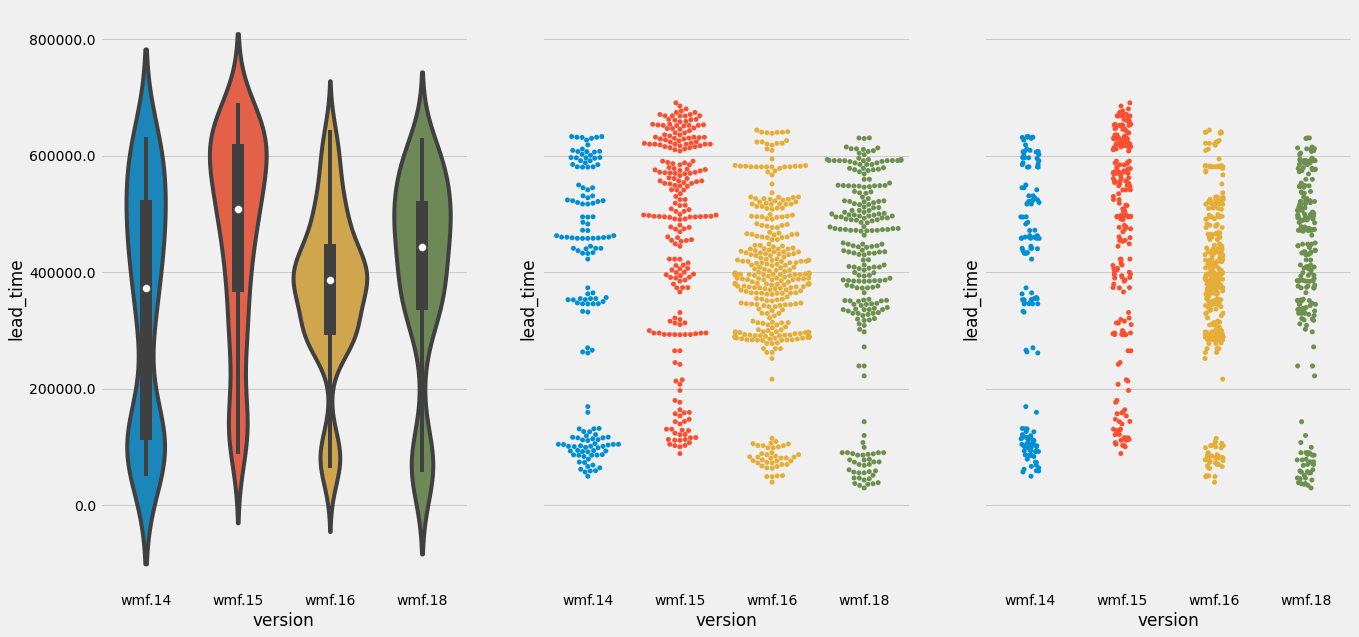

In [36]:
from matplotlib import ticker as mticker
import numpy as np

# Adapted from <https://stackoverflow.com/a/60132262>
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20,10))
sns.violinplot(data=cycle,x='version', y='lead_time', ax=ax[0])
sns.swarmplot(data=cycle,x='version', y='lead_time', ax=ax[1])
sns.stripplot(data=cycle,x='version', y='lead_time', ax=ax[2])
ax[0].yaxis.set_major_formatter(mticker.StrMethodFormatter("{x}"))
ax[0].yaxis.set_ticks([np.log10(x) for p in range(-6,1) for x in np.linspace(10**p, 10**(p+1), 10)], minor=True)
plt.show()

### Cycle time

The time from patchset submission for code review to deploy

/usr/lib/python3/dist-packages/seaborn/categorical.py:1296: UserWarning: 71.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/lib/python3/dist-packages/seaborn/categorical.py:1296: UserWarning: 70.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/lib/python3/dist-packages/seaborn/categorical.py:1296: UserWarning: 85.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/lib/python3/dist-packages/seaborn/categorical.py:1296: UserWarning: 73.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


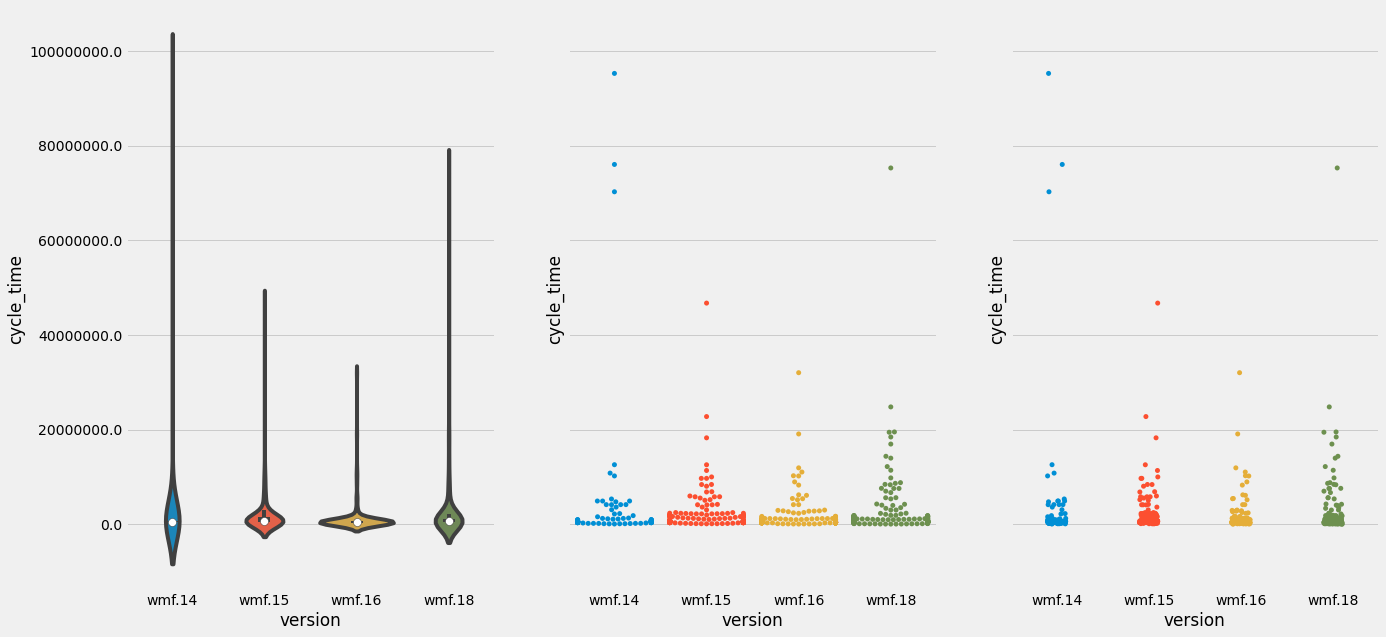

In [37]:
from matplotlib import ticker as mticker
import numpy as np

# Adapted from <https://stackoverflow.com/a/60132262>
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20,10))
sns.violinplot(data=cycle,x='version', y='cycle_time', ax=ax[0])
sns.swarmplot(data=cycle,x='version', y='cycle_time', ax=ax[1])
sns.stripplot(data=cycle,x='version', y='cycle_time', ax=ax[2])
ax[0].yaxis.set_major_formatter(mticker.StrMethodFormatter("{x}"))
ax[0].yaxis.set_ticks([np.log10(x) for p in range(-6,1) for x in np.linspace(10**p, 10**(p+1), 10)], minor=True)
plt.show()